In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
sns.set()

In [14]:
data = defaultdict(list)
time = 0
rss = 0
ds_type = None
threads = 0
file_count = 0
with open("res.txt") as in_f:
    for line in in_f:
        if "CBL/target/release" in line:
            ds_type = "CBL"
            threads = 1
            file_count = int(line.split("/")[-1].split(".")[0])
        elif "bufboss/bin/" in line:
            ds_type = "Bufboss"
        elif "bifrost/build/bin" in line:
            ds_type = "Bifrost"
        elif "BBB/build/bin" in line:
            ds_type = "BSBWT"
        elif line.startswith("threads = "):
            threads = int(line.split()[-1])
        elif "maxresident" in line:
            for field in line.split():
                if "elapsed" in field:
                    minutes, seconds = field[:-7].split(':', maxsplit=1)
                    time = int(minutes) * 60 + float(seconds)
                elif "maxresident" in field:
                    rss = int(field[:-13])
                    data[f"{ds_type}-{threads}"].append((time, rss))
            

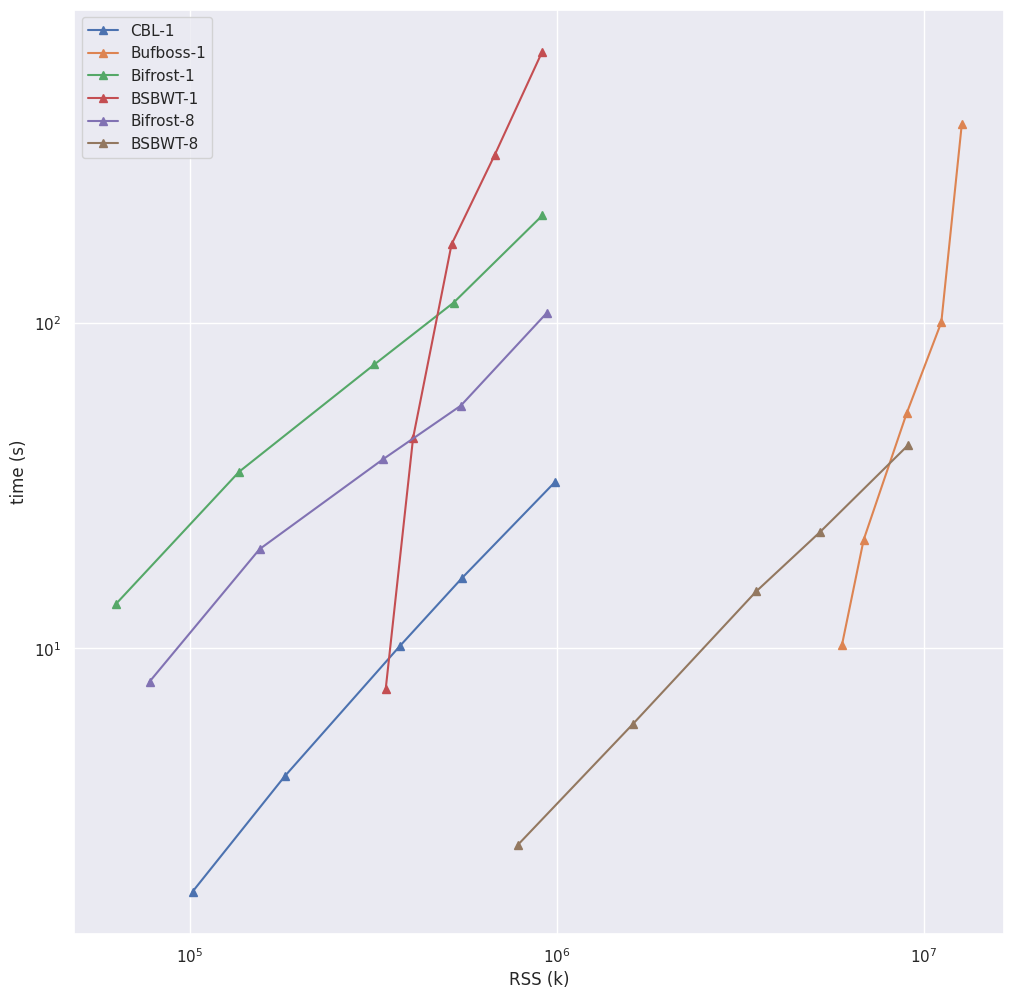

In [22]:
plt.figure(figsize=(12, 12))
for k, v in data.items():
    plt.plot([vv[1] for vv in v], [vv[0] for vv in v], label=k, marker="^")
plt.ylabel("time (s)")
plt.xlabel("RSS (k)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()